In [1]:

import torch 
from scipy.signal import find_peaks
from  src.utils import create_uniform_energy_grid, shift_test_batch
from  src.models import MultiClassifierV2_STN, STNClassifier, MLPClassifier


In [2]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optionally, you can print more details about the GPU if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

Using device: cuda
GPU Name: Tesla T4
Number of GPUs available: 1


In [3]:
import torch

# Load the entire dictionary object
test_data = torch.load('../data/synthetic_data_hard_final/test_data.pt')

# Access each item by its key
X_test = test_data['features']
y_test = test_data['labels']


# Now you can use these tensors for evaluation
print(f"Loaded features shape: {X_test.shape}")
print(f"Loaded labels shape: {y_test.shape}")

# If you need a DataLoader for batching during evaluation:
from torch.utils.data import TensorDataset, DataLoader

test_dataset = TensorDataset(X_test, y_test)
test_loader_new = DataLoader(test_dataset, batch_size=64, shuffle=False)

Loaded features shape: torch.Size([20000, 6601])
Loaded labels shape: torch.Size([20000, 40])


In [4]:
from  src.utils import preprocess_data_for_cvae


__ , quant_test_loader, input_features, output_features = preprocess_data_for_cvae(
    spectra_dir= '../data/synthetic_data_hard_final/synthetic_spectra',
    labels_dir='../data/synthetic_data_hard_final/synthetic_labels',
    max_shift=0.0,
    energy_resolution=0.1, 
    test_size=0.2,
    random_seed=42,
    batch_size=64)

quant_test_dataset = quant_test_loader.dataset




In [5]:
all_quant_labels = torch.stack([y for _, y in quant_test_dataset])
all_quant_spectra  = torch.stack([x for x, _ in quant_test_dataset])

Quantized label: ['0.17  naphthalene', '0.05  ester (aliphatic)', '0.77  alkane']
Binned label: ['1.00  naphthalene', '1.00  ester (aliphatic)', '1.00  alkane']


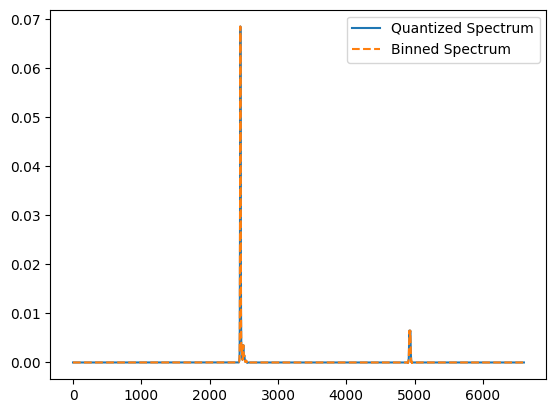

In [33]:
from src.utils import label_converter
import json
import matplotlib.pyplot as plt

with open("../data/FG_list.json", "r") as f:
    FG_list= json.load(f) 

i = 0


quant_readable_label = label_converter(all_quant_labels[i], FG_list)
bin_readable_label = label_converter(y_test[i], FG_list)

print("Quantized label:", quant_readable_label)
print("Binned label:", bin_readable_label)

quant_spectrum = all_quant_spectra[i].numpy()
bin_spectrum = X_test[i].numpy()

plt.plot(quant_spectrum, label='Quantized Spectrum')
plt.plot(bin_spectrum, label='Binned Spectrum', linestyle='--')
plt.legend()



In [13]:
from src.models import STNClassifier, MLPClassifier, CNNClassifier
from pathlib import Path

# 4. Create an instance of the model and send it to target device
model_0 =  CNNClassifier().to(device)
model_architecture_name = "CNNClassifier"

# Load the saved model
model_path = Path("../models/CNNClassifier_shift_3.0eV_model.pth")
#model_path = Path("../../../local_models/STN_3_shift.pth")

model_0.load_state_dict(torch.load(model_path))
model_0.eval()

CNNClassifier(
  (feature_extractor): CNN1DFeatureExtractor(
    (conv1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool): AdaptiveAvgPool1d(output_size=6601)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): MLPClassifier(
    (layer_1): Linear(in_features=6601, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_2): Linear(in_features=256, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_3): Linear(in_features=128, out_features=40, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [14]:
MAX_SHIFT_IN_INDICES = 30
# Create the new, randomly shifted test set
X_test_shifted = shift_test_batch(X_test, MAX_SHIFT_IN_INDICES)
X_test_shifted = X_test_shifted.to(device)

# --- Now run inference using the SHIFTED data ---
with torch.inference_mode():
    # Pass the shifted tensor to your model
    if isinstance(model_0, STNClassifier):
        test_logits, aligned_spectra = model_0(X_test_shifted)
    else:
        test_logits  = model_0(X_test_shifted)
    
    # The rest of your code remains the same...
    test_pred = torch.round(torch.sigmoid(test_logits.squeeze()))

print("✅ Inference complete on randomly shifted test data.")

✅ Inference complete on randomly shifted test data.


In [16]:
y_test_np = y_test.cpu().numpy()
test_pred_np = test_pred.cpu().numpy()


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # Check if all 39 classes match for each sample
    correct = (y_true == y_pred).all(axis=1).sum().item()  # Use .all(axis=1) to check all classes
    acc = (correct / len(y_true)) * 100  # Calculate accuracy as a percentage
    return acc 

exact_match_accuracy = accuracy_fn(y_true=y_test_np, y_pred=test_pred_np)

print("\n" + "="*50)
print("--- Accuracy Calculation Results ---")
print(f"The exact match accuracy on the shifted test data is: {exact_match_accuracy:.2f}%")
print("="*50)


--- Accuracy Calculation Results ---
The exact match accuracy on the shifted test data is: 36.69%


# Investigating detection limits 
(how composition ratio relates to probability of detection)


plot saved to: ../final_results/CNNClassifier_recall_vs_conc.svg


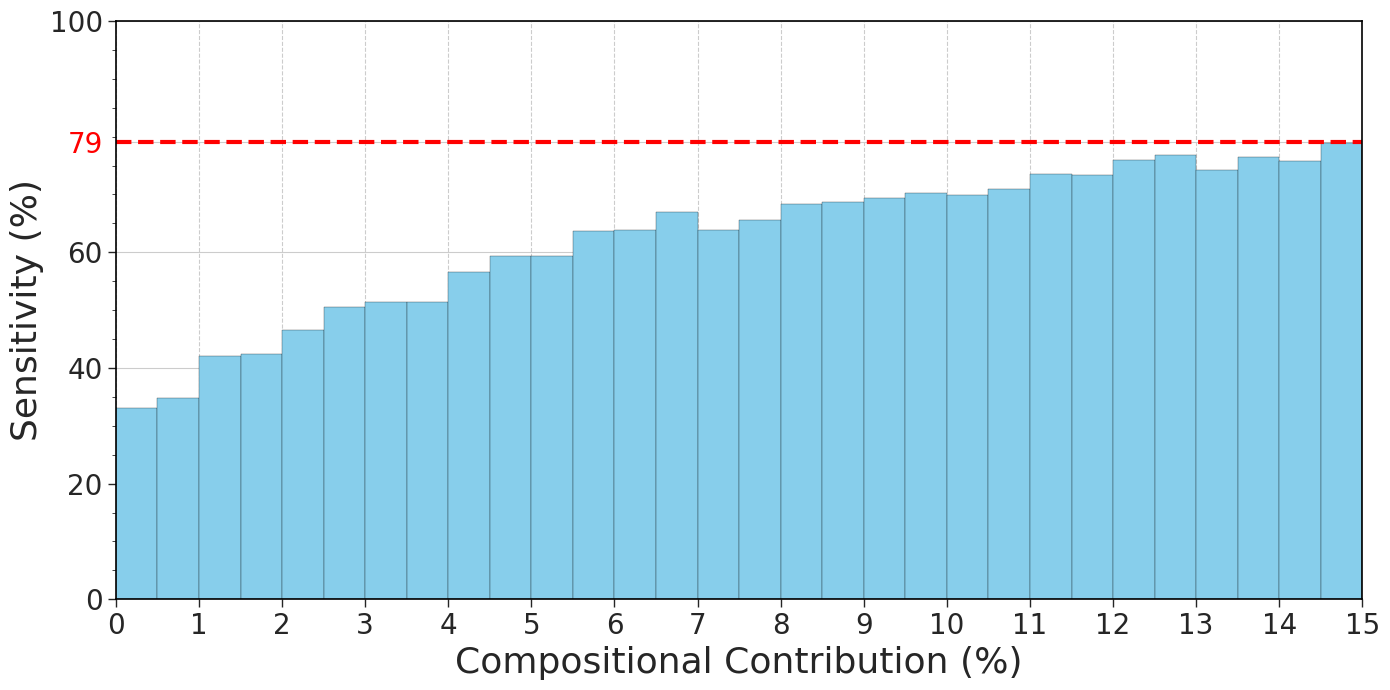

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import pandas as pd
import numpy as np

def plot_sensitivity_vs_composition(y_true, y_pred, quant_labels, bins=200, xlim_pct=(0, 20)):
    # ... (The data processing part of your function remains unchanged) ...
    df = pd.DataFrame({
        'composition': quant_labels.flatten(),
        'true_label': y_true.flatten(),
        'pred_label': y_pred.flatten()
    })
    bin_edges = np.linspace(0, 1, bins + 1)
    df['comp_bin'] = pd.cut(df['composition'], bins=bin_edges, right=False)
    df['is_tp'] = (df['true_label'] == 1) & (df['pred_label'] == 1)
    df['is_fn'] = (df['true_label'] == 1) & (df['pred_label'] == 0)
    grouped_counts = df.groupby('comp_bin', observed=False)[['is_tp', 'is_fn']].sum()
    tp = grouped_counts['is_tp']
    fn = grouped_counts['is_fn']
    sensitivity_by_bin = tp.div(tp + fn).fillna(0) * 100
    # ---

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7))

    bin_midpoints_pct = np.array([(b.left + b.right) / 2 * 100 for b in sensitivity_by_bin.index])
    bar_width = 100 / bins

    ax.bar(
        x=bin_midpoints_pct, height=sensitivity_by_bin.values, width=bar_width,
        color='skyblue', edgecolor='k', linewidth=0.20
    )

    ax.set_xlabel('Compositional Contribution (%)', fontsize=26)
    ax.set_ylabel('Sensitivity (%)', fontsize=26)
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.2) # Set the thickness
        spine.set_color('black') # Set the color

    ax.set_xlim(left=0, right=xlim_pct[1]) # Set left limit to 0 for the new origin
    ax.set_ylim(bottom=0, top=100)       # Set bottom limit to 0 for the new origin

    # --- NEW: Add and style tick marks ---
    # Style the major ticks to be prominent
    ax.tick_params(axis='both', which='major', labelsize=20, direction='out', length=6, width=1)
    # Add minor ticks on the x-axis for better readability
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.5))

    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.grid(which='major', axis='x', linestyle='--')

        
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(5))  # every 5%
    ax.tick_params(axis='y', which='minor', length=3)       # small tick marks

    # --- Overall Sensitivity Line and Custom Tick ---
    overall_tp = df['is_tp'].sum()
    overall_fn = df['is_fn'].sum()
    overall_sensitivity = (overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0) * 100
    ax.axhline(y=overall_sensitivity, color='r', linestyle='--',linewidth=3)
    
    current_ticks = ax.get_yticks()
    new_tick = overall_sensitivity
    final_ticks = [t for t in current_ticks if abs(t - new_tick) > 4]
    final_ticks.append(new_tick)
    
    final_labels = []
    for tick in sorted(final_ticks):
        if np.isclose(tick, new_tick):
            final_labels.append(f'{new_tick:.0f}')
        else:
            final_labels.append(f'{tick:.0f}')
            
    ax.set_yticks(sorted(final_ticks))
    ax.set_yticklabels(final_labels)
    fig.canvas.draw()
    # Loop through labels AND ticks to apply custom styling
    for label, tick_object in zip(ax.get_yticklabels(), ax.yaxis.get_major_ticks()):
        if np.isclose(tick_object.get_loc(), new_tick):
            label.set_color('red')
            label.set_fontsize(20)
            label.set_ha('right')
            label.set_multialignment('right')
        
            tick_object.tick1line.set_visible(False)

            
    plt.tight_layout()

# --- Call the function ---

plot_sensitivity_vs_composition(y_test_np, test_pred_np, all_quant_labels, bins=200, xlim_pct=(0, 15))

#Save the Figure 
# Create the output directory if it doesn't exist
output_dir = Path("../final_results")
output_dir.mkdir(parents=True, exist_ok=True)

# Define the output filename dynamically
output_filename = output_dir / f"{model_architecture_name}_recall_vs_conc.svg"

# Save the figure
plt.savefig(output_filename, format='svg', bbox_inches='tight')
print(f"\nplot saved to: {output_filename}")

plt.show()


# Investigating Per-Class Performance

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np
import json





# Calculate the confusion matrix for each class
num_classes = y_test_np.shape[1]
confusion_matrices = []
for i in range(num_classes):
    # Get the labels for the current class
    y_true_class = y_test_np[:, i]
    y_pred_class = test_pred_np[:, i]
    
    # Calculate the 2x2 confusion matrix (TN, FP, FN, TP)
    # The labels=[0, 1] argument ensures the matrix has a 2x2 shape
    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    confusion_matrices.append(cm)

# Print the confusion matrix for each class
for i, matrix in enumerate(confusion_matrices):
    print(f"\nConfusion Matrix for Class {i}:")
    print(matrix)

# --- 7. Aggregate Confusion Matrix and Overall Metrics ---
print("\n" + "="*50)
print("--- Aggregate Performance Metrics ---")
print("="*50)

# Sum all the per-class confusion matrices to get an aggregate matrix
aggregate_cm = np.sum(confusion_matrices, axis=0)
print("\nAggregate Confusion Matrix:")
print(aggregate_cm)

# Extract TN, FP, FN, TP from the aggregate matrix
agg_tn, agg_fp, agg_fn, agg_tp = aggregate_cm.ravel()

# Calculate overall sensitivity (recall) and precision
# Add a small epsilon to avoid division by zero
epsilon = 1e-10
sensitivity = agg_tp / (agg_tp + agg_fn + epsilon)
precision = agg_tp / (agg_tp + agg_fp + epsilon)
specificity = agg_tn / (agg_tn + agg_fp + epsilon)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + epsilon)

print("\nOverall Metrics:")
print(f"  - Sensitivity (Recall): {sensitivity:.2%}")
print(f"  - Precision:            {precision:.2%}")
print(f"  - Specificity:          {specificity:.2%}")
print(f"  - F1-Score:             {f1_score:.4f}")
print("="*50)


Confusion Matrix for Class 0:
[[17665    76]
 [  365  1894]]

Confusion Matrix for Class 1:
[[20000     0]
 [    0     0]]

Confusion Matrix for Class 2:
[[10451    22]
 [  383  9144]]

Confusion Matrix for Class 3:
[[19549     0]
 [   54   397]]

Confusion Matrix for Class 4:
[[16846     4]
 [  128  3022]]

Confusion Matrix for Class 5:
[[19549     0]
 [   24   427]]

Confusion Matrix for Class 6:
[[18146    44]
 [  398  1412]]

Confusion Matrix for Class 7:
[[16807    14]
 [  166  3013]]

Confusion Matrix for Class 8:
[[13108   109]
 [  438  6345]]

Confusion Matrix for Class 9:
[[17735     0]
 [   11  2254]]

Confusion Matrix for Class 10:
[[18168     0]
 [   26  1806]]

Confusion Matrix for Class 11:
[[20000     0]
 [    0     0]]

Confusion Matrix for Class 12:
[[20000     0]
 [    0     0]]

Confusion Matrix for Class 13:
[[20000     0]
 [    0     0]]

Confusion Matrix for Class 14:
[[20000     0]
 [    0     0]]

Confusion Matrix for Class 15:
[[19532     1]
 [   55   412]]

C

In [11]:
import json 


with open("../data/FG_list.json", "r") as f:
    FG_list= json.load(f) 
    
# --- 2. Calculate and Store Labeled Confusion Matrices ---
num_classes = y_test_np.shape[1]
labeled_confusion_matrices = {}

for i in range(num_classes):
    class_name = FG_list[i]
    
    # Get the labels for the current class
    y_true_class = y_test_np[:, i]
    y_pred_class = test_pred_np[:, i]
    
    # Calculate the 2x2 confusion matrix (TN, FP, FN, TP)
    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0, 1])
    
    # Store the matrix in the dictionary with its class name as the key.
    # .tolist() converts the NumPy array to a standard Python list for JSON compatibility.
    labeled_confusion_matrices[class_name] = cm.tolist()

print(f"Calculated confusion matrices for {len(labeled_confusion_matrices)} classes.")


# --- 3. Save the Labeled Matrices to a JSON File ---
# Define the output directory and filename
output_dir = Path("../final_results")
output_dir.mkdir(parents=True, exist_ok=True)
model_architecture_name = model_0.__class__.__name__
output_filename = output_dir / f"{model_architecture_name}_per_class_cms.json"


# Save the dictionary to the JSON file
with open(output_filename, 'w') as f:
    json.dump(labeled_confusion_matrices, f, indent=4)

print(f"\n✅ Per-class confusion matrices successfully saved to:\n{output_filename}")

# Optional: Print the first few entries to verify
print("\n--- Example Output (first 3 classes) ---")
for i, (class_name, matrix) in enumerate(labeled_confusion_matrices.items()):
    if i >= 3:
        break
    print(f"'{class_name}': {matrix}")



Calculated confusion matrices for 40 classes.

✅ Per-class confusion matrices successfully saved to:
../final_results/STNClassifier_per_class_cms.json

--- Example Output (first 3 classes) ---
'alkene': [[17665, 76], [365, 1894]]
'alkyne': [[20000, 0], [0, 0]]
'benzene ring': [[10451, 22], [383, 9144]]


Successfully loaded 40 per-class confusion matrices from 'STNClassifier_per_class_cms.json'.
Aggregating results from 32 classes that were present in the test set.

--- Aggregate Performance Metrics ---

Aggregate Confusion Matrix:
[[559885    699]
 [  3857  75559]]

Overall Metrics (for classes present in test set):
  - Sensitivity (Recall): 95.14%
  - Precision:            99.08%
  - Specificity:          99.88%
  - F1-Score:             0.9707

Heatmap saved to: ../final_results/STNClassifier_confusion_matrix.svg


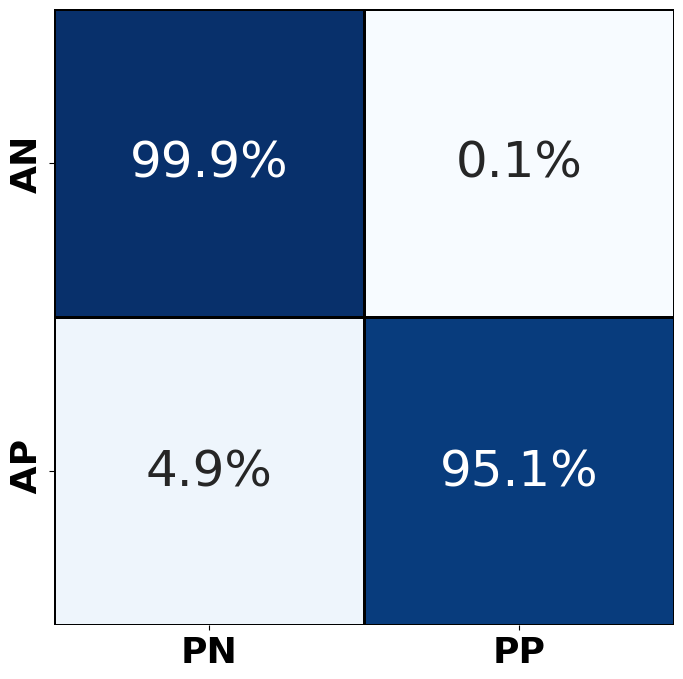

In [12]:
import numpy as np
import json
from pathlib import Path

# --- 1. Configuration ---
# Define the path to the JSON file containing the per-class confusion matrices

model_architecture_name = 'STNClassifier'
output_filename = output_dir / f"{model_architecture_name}_per_class_cms.json"
INPUT_JSON_PATH = output_filename

# --- 2. Load and Process Data ---
try:
    with open(INPUT_JSON_PATH, 'r') as f:
        labeled_cms = json.load(f)
    print(f"Successfully loaded {len(labeled_cms)} per-class confusion matrices from '{INPUT_JSON_PATH.name}'.")

    # --- 3. Aggregate Matrices (excluding classes with no positive samples) ---
    # Initialize counters
    agg_tn, agg_fp, agg_fn, agg_tp = 0, 0, 0, 0
    included_classes = []

    # Loop through each class and its confusion matrix
    for class_name, matrix in labeled_cms.items():
        # matrix is [[TN, FP], [FN, TP]]
        tn, fp = matrix[0]
        fn, tp = matrix[1]
        
        # Check if the class was actually present in the test set (TP + FN > 0)
        if (tp + fn) > 0:
            agg_tn += tn
            agg_fp += fp
            agg_fn += fn
            agg_tp += tp
            included_classes.append(class_name)
    
    print(f"Aggregating results from {len(included_classes)} classes that were present in the test set.")
    
    # Create the final aggregate confusion matrix as a NumPy array
    aggregate_cm = np.array([[agg_tn, agg_fp], [agg_fn, agg_tp]])

    # --- 4. Calculate and Print Aggregate Metrics ---
    print("\n" + "="*50)
    print("--- Aggregate Performance Metrics ---")
    print("="*50)

    print("\nAggregate Confusion Matrix:")
    print(aggregate_cm)

    # Calculate overall sensitivity (recall), precision, etc.
    # Add a small epsilon to avoid division by zero if a denominator is 0
    epsilon = 1e-10
    sensitivity = agg_tp / (agg_tp + agg_fn + epsilon)
    precision = agg_tp / (agg_tp + agg_fp + epsilon)
    specificity = agg_tn / (agg_tn + agg_fp + epsilon)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + epsilon)

    print("\nOverall Metrics (for classes present in test set):")
    print(f"  - Sensitivity (Recall): {sensitivity:.2%}")
    print(f"  - Precision:            {precision:.2%}")
    print(f"  - Specificity:          {specificity:.2%}")
    print(f"  - F1-Score:             {f1_score:.4f}")
    print("="*50)

except FileNotFoundError:
    print(f"Error: Input file not found at '{INPUT_JSON_PATH}'")
except Exception as e:
    print(f"An error occurred: {e}")


import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentages for the heatmap colors (row-normalized for recall/sensitivity view)
aggregate_cm_percent = aggregate_cm.astype('float') / (aggregate_cm.sum(axis=1)[:, np.newaxis] + epsilon)

# Create labels for the heatmap cells (showing both percentage and raw count)
labels = (
    np.array([
        [f"{aggregate_cm_percent[0,0]:.1%}", f"{aggregate_cm_percent[0,1]:.1%}"],
        [f"{aggregate_cm_percent[1,0]:.1%}", f"{aggregate_cm_percent[1,1]:.1%}"]
    ])
)

# Create the plot
plt.figure(figsize=(8, 8))
sns.heatmap(
    aggregate_cm_percent, 
    annot=labels, 
    fmt='',  # Use the custom labels, not a numeric format string
    cmap='Blues', 
    cbar=False,
    annot_kws={"size": 36},
    linewidths=2,          # thickness of the grid lines
    linecolor='black'
)

plt.xticks(ticks=[0.5, 1.5], labels=['PN' ,'PP'], fontsize=26, fontweight='bold')
plt.yticks(ticks=[0.5, 1.5], labels=['AN', ' AP'] , rotation=90, va='center', fontsize=26, fontweight='bold')



# --- 9. Save the Figure ---
# Create the output directory if it doesn't exist
output_dir = Path("../final_results")
output_dir.mkdir(parents=True, exist_ok=True)

# Define the output filename

# Define the output filename dynamically
output_filename = output_dir / f"{model_architecture_name}_confusion_matrix.svg"

# Save the figure
plt.savefig(output_filename, format='svg', bbox_inches='tight')
print(f"\nHeatmap saved to: {output_filename}")
# --------------------------

plt.show()


In [1]:
import pandas as pd
import json
from pathlib import Path
import numpy as np

# --- 1. Configuration ---
# Define the models to compare
MODELS_TO_COMPARE = ['MLPClassifier', 'CNNClassifier', 'STNClassifier']
# Define the reference model to find the worst classes from
REFERENCE_MODEL = 'MLPClassifier'
# Define the base path for the input files
BASE_INPUT_PATH = Path("../final_results")


# --- 2. Load and Calculate Sensitivities for ALL Models ---
all_model_sensitivities = {}
epsilon = 1e-10  # To avoid division by zero

for model_name in MODELS_TO_COMPARE:
    input_path = BASE_INPUT_PATH / f"{model_name}_per_class_cms.json"
    
    try:
        with open(input_path, 'r') as f:
            labeled_cms = json.load(f)
        print(f"Successfully loaded data for {model_name}.")

        class_sensitivities = {}
        # Loop through each class and its confusion matrix
        for class_name, matrix in labeled_cms.items():
            tn, fp = matrix[0]
            fn, tp = matrix[1]
            
            # Only calculate sensitivity for classes that were present in the test set
            if (tp + fn) > 0:
                sensitivity = tp / (tp + fn + epsilon)
                class_sensitivities[class_name] = sensitivity
        
        # Store the results in the master dictionary
        all_model_sensitivities[model_name] = class_sensitivities

    except FileNotFoundError:
        print(f"Warning: Could not find input file for {model_name} at '{input_path}'. Skipping.")
        continue
    except Exception as e:
        print(f"An error occurred while processing {model_name}: {e}")
        continue


# --- 3. Identify Worst Classes for the Reference Model (MLP) ---
if REFERENCE_MODEL in all_model_sensitivities:
    # Convert the MLP sensitivities to a DataFrame for sorting
    mlp_sens_df = pd.DataFrame(
        list(all_model_sensitivities[REFERENCE_MODEL].items()),
        columns=['Class Name', 'MLP Sensitivity']
    )
    
    # Sort by sensitivity in ascending order and get the top 10
    worst_classes_df = mlp_sens_df.sort_values(by='MLP Sensitivity', ascending=True)

    # --- 4. Look Up and Add Sensitivities for Other Models ---
    for model_name in MODELS_TO_COMPARE:
        if model_name == REFERENCE_MODEL:
            continue # Skip the MLP since we already have it

        # Use the list of worst class names to look up their sensitivities in other models
        # .get(class_name, np.nan) will return NaN if a class is not found in another model's results
        worst_classes_df[f'{model_name} Sensitivity'] = worst_classes_df['Class Name'].apply(
            lambda class_name: all_model_sensitivities.get(model_name, {}).get(class_name, np.nan)
        )

    # --- 5. Format and Display the Final Table ---
    print("\n" + "="*80)
    print(f"--- Top 10 Worst Performing Classes for {REFERENCE_MODEL} and Comparison ---")
    print("="*80)

    # Create a copy for formatting to avoid SettingWithCopyWarning
    display_df = worst_classes_df.copy()
    
    # Format all sensitivity columns as percentages
    for col in display_df.columns:
        if 'Sensitivity' in col:
            display_df[col] = display_df[col].map('{:.2%}'.format)

    # Print the final table without the index
    print(display_df.to_string(index=False))

    # --- 6. Save the DataFrame to a CSV file ---
    BASE_PATH = Path("../final_results")
    # Ensure the output directory exists
    BASE_PATH.mkdir(parents=True, exist_ok=True) 

    output_filename = BASE_PATH / "worst_performing_classes_comparison.csv"

    # Save the DataFrame with the raw sensitivity values (not the formatted percentages)
    worst_classes_df.to_csv(output_filename, index=False)

    print(f"\n✅ Comparison data permanently saved to: {output_filename}")

else:
    print(f"Could not generate report because the reference model '{REFERENCE_MODEL}' was not found.")

Successfully loaded data for MLPClassifier.
Successfully loaded data for CNNClassifier.
Successfully loaded data for STNClassifier.

--- Top 10 Worst Performing Classes for MLPClassifier and Comparison ---
         Class Name MLP Sensitivity CNNClassifier Sensitivity STNClassifier Sensitivity
            epoxide           5.86%                     0.00%                    63.06%
          anhydride          37.50%                     5.58%                    79.24%
alcohol (aliphatic)          43.54%                    24.25%                    78.01%
        naphthalene          46.56%                     2.88%                    88.03%
    carboxylic acid          52.66%                    27.66%                    84.36%
             alkene          56.13%                    29.08%                    83.84%
  ketone (aromatic)          56.96%                    27.19%                    88.22%
   ester (aromatic)          66.25%                    46.78%                    92.17%
  

# Plot of accuracy when trained/tested at different levels of shift applied:

Plot successfully saved to: ../final_results/shift_performance_plot.svg


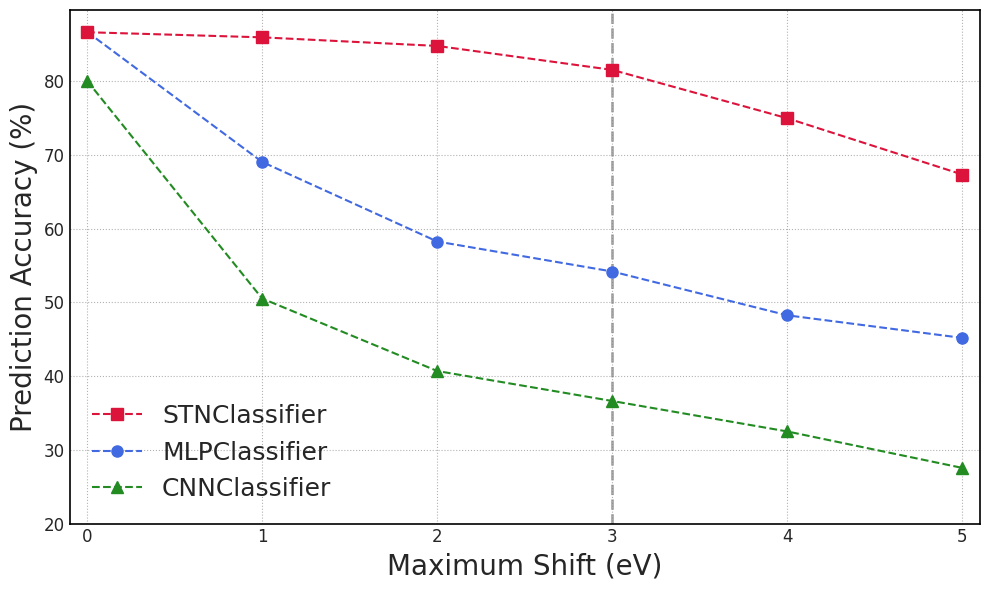

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 2. Load Data into DataFrame ---
# Use io.StringIO to treat the string data as a file
df = pd.read_csv('../final_results/shift_experiment_results.csv')

# --- 3. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Define styles for each model
styles = {
    'CNNClassifier': {'color': 'forestgreen', 'marker': '^', 'linestyle': '--'},
    'STNClassifier': {'color': 'crimson', 'marker': 's', 'linestyle': '--'},
    'MLPClassifier': {'color': 'royalblue', 'marker': 'o', 'linestyle': '--'},
}

# Group data by model and plot each one
for model_name, group in df.groupby('model'):
    # Sort by shift value to ensure the line plots correctly
    group = group.sort_values('max_shift')
    
    style = styles.get(model_name, {})
    ax.plot(
        group['max_shift'],
        group['best_test_accuracy'],
        label=model_name,
        color=style.get('color'),
        marker=style.get('marker'),
        linestyle=style.get('linestyle'),
        markersize=8
    )

# --- 4. Aesthetics ---
ax.set_xlabel('Maximum Shift (eV)', fontsize=20)
ax.set_ylabel('Prediction Accuracy (%)', fontsize=20)


handles, labels = ax.get_legend_handles_labels()

# Define the desired order of the labels
desired_order = ['STNClassifier', 'MLPClassifier', 'CNNClassifier']

# Create a dictionary to map labels to their handles
handle_map = dict(zip(labels, handles))

# Create the reordered lists
reordered_handles = [handle_map[label] for label in desired_order if label in handle_map]
reordered_labels = [label for label in desired_order if label in handle_map]

# Create the legend with the reordered items
ax.legend(handles=reordered_handles, labels=reordered_labels, fontsize=18, loc='lower left')

ax.tick_params(axis='both', which='major', labelsize=12)

# Set y-axis limit to start from a reasonable value, e.g., 20%
ax.set_ylim(bottom=20)
ax.set_xlim(df['max_shift'].min() - 0.1, df['max_shift'].max() + 0.1)

# Add a vertical line at x=3.0 eV to mark a key shift value
ax.axvline(x=3.0, color='darkgray', linestyle='--', linewidth=2, zorder=0)

# Customize the grid to be dotted and gray
ax.grid(True, linestyle=':', color='gray', alpha=0.6)

for spine in ax.spines.values():
        spine.set_linewidth(1.2) # Set the thickness
        spine.set_color('black') # Set the color

plt.tight_layout()


# --- 5. Save the Figure ---
# Define the output directory and ensure it exists
output_dir = Path("../final_results")
output_dir.mkdir(parents=True, exist_ok=True)

# Define the output filename
output_filename = output_dir / "shift_performance_plot.svg"

# Save the figure
plt.savefig(output_filename, format='svg', bbox_inches='tight')
print(f"Plot successfully saved to: {output_filename}")
plt.show()


[169.6 170.6 286.9 290.5 293.2 293.6 402.4 533.8 535.4]
[167.6 168.8 284.9 288.5 291.2 291.6 400.4 531.9 533.4]


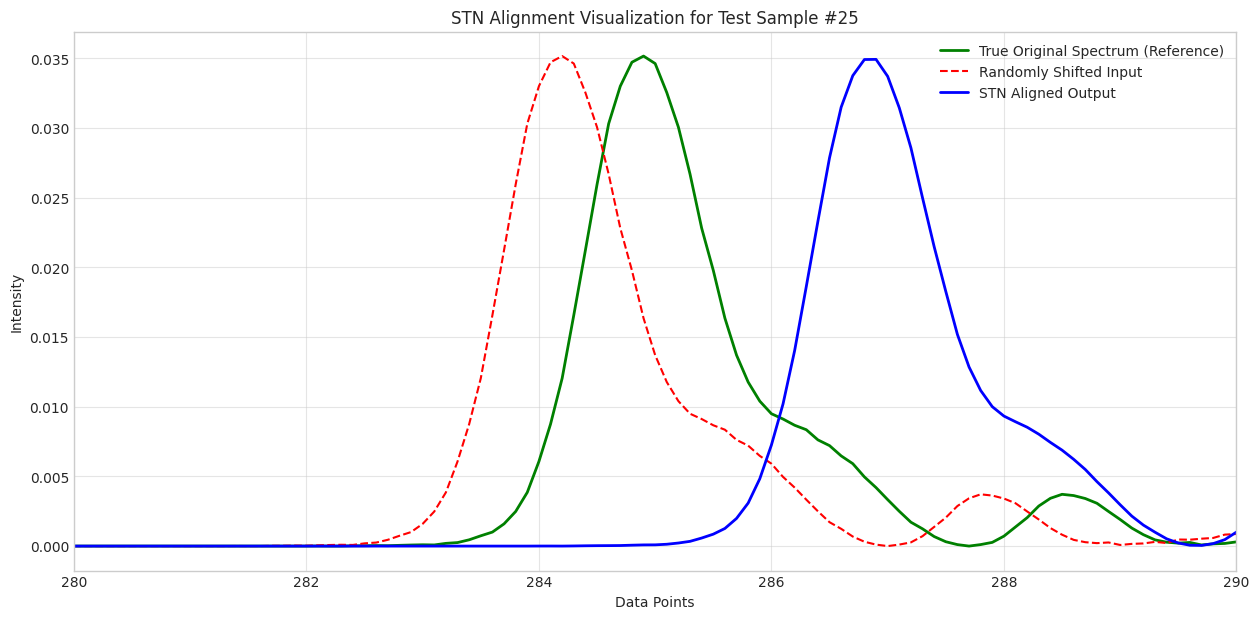

In [154]:
import matplotlib.pyplot as plt
import numpy as np


valence_region_index =400 
start_energy, end_energy = (0,700)

BE_values = create_uniform_energy_grid(start_energy, end_energy)[valence_region_index:]

# Choose an index to inspect
index = 25

# --- Retrieve all three versions of the spectrum ---
# 1. The true original spectrum (before any shifting)
true_original_spec = X_test[index].cpu().numpy()

# 2. The randomly shifted spectrum that was fed into the model
shifted_input_spec = X_test_shifted[index].cpu().numpy()

# 3. The spectrum after the STN tried to align it
aligned_output_spec = aligned_spectra[index].cpu().numpy()


# --- Create the plot ---
plt.figure(figsize=(15, 7))

# Plot the true original spectrum as a reference
plt.plot(BE_values, true_original_spec, label='True Original Spectrum (Reference)', color='green', linewidth=2)

# Plot the randomly shifted input
plt.plot(BE_values, shifted_input_spec, label='Randomly Shifted Input', color='red', linestyle='--')

# Plot the STN's aligned output
plt.plot(BE_values, aligned_output_spec, label='STN Aligned Output', color='blue', linewidth=2)

alligned_peaks, properties = find_peaks(aligned_output_spec, height=0.001, width =1)
print((alligned_peaks+400)/10)


original_peaks, properties = find_peaks(true_original_spec, height=0.001, width =1)
print((original_peaks+400)/10)

plt.title(f"STN Alignment Visualization for Test Sample #{index}")
plt.xlabel("Data Points")
plt.ylabel("Intensity")
plt.legend()
plt.xlim(280,290) # Keep the zoom on the area of interest
plt.grid(True, alpha=0.5)
plt.show()


Plot successfully saved to: ../final_results/shifted_examples.svg


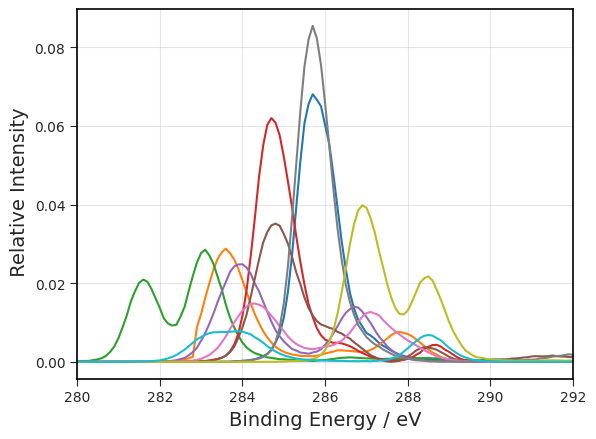

In [180]:
example_indices = list(range(20,30,1))

for index in example_indices:
    shifted_input_spec = X_test_shifted[index].cpu().numpy()
    plt.plot(BE_values, shifted_input_spec, label='STN Aligned Output')

# Get current axes
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.2) # Set the thickness
        spine.set_color('black') # Set the color
    
plt.xlabel("Binding Energy / eV", fontsize=14)
plt.ylabel(" Relative Intensity", fontsize=14)
plt.xlim(280,292) # Keep the zoom on the area of interest
plt.grid(True, alpha=0.5)
ax.tick_params(axis='x', which='both', length=5, direction='out', top=False, bottom=True)
ax.tick_params(axis='y', which='both', length=5, direction='out', left=True, right=False)

# Save the figure
output_dir = Path("../final_results")
output_filename = output_dir / "shifted_examples.svg"
#plt.savefig(output_filename, format='svg', bbox_inches='tight')
print(f"\nPlot successfully saved to: {output_filename}")


plt.show()
    


Plot successfully saved to: ../final_results/alligned_examples.svg


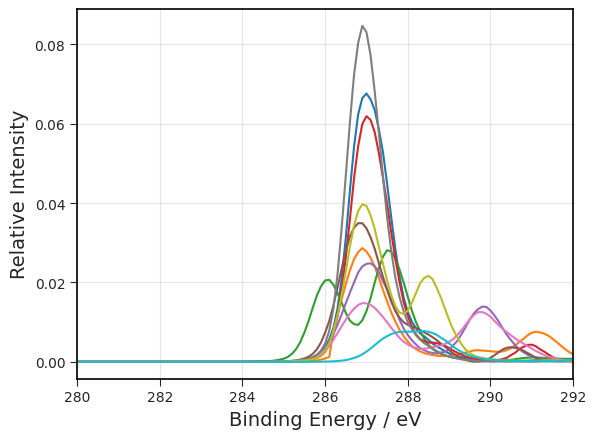

In [181]:

for index in example_indices:
    aligned_output_spec = aligned_spectra[index].cpu().numpy()
    plt.plot(BE_values, aligned_output_spec, label='STN Aligned Output')
    


# Get current axes
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.2) # Set the thickness
        spine.set_color('black') # Set the color

        
plt.xlabel("Binding Energy / eV", fontsize=14)
plt.ylabel("Relative Intensity", fontsize=14)
plt.xlim(280,292) # Keep the zoom on the area of interest
plt.grid(True, alpha=0.5)
ax.tick_params(axis='x', which='both', length=5, direction='out', top=False, bottom=True)
ax.tick_params(axis='y', which='both', length=5, direction='out', left=True, right=False)


output_dir = Path("../final_results")
output_filename = output_dir / "alligned_examples.svg"
plt.savefig(output_filename, format='svg', bbox_inches='tight')
print(f"\nPlot successfully saved to: {output_filename}")

plt.show()
    


Plot successfully saved to: ../final_results/original_unshifted_examples.svg


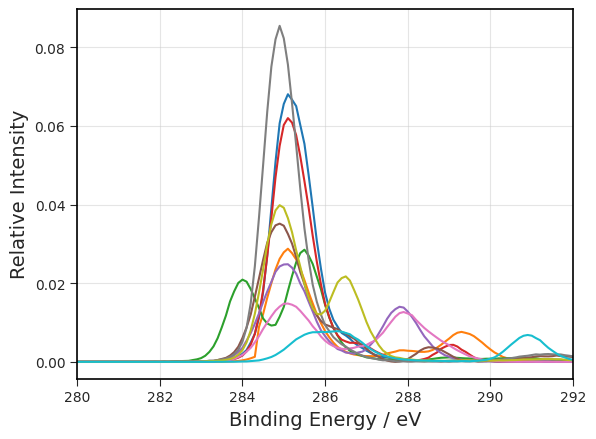

In [182]:
from src.utils import label_converter


for index in example_indices:
    true_original_spec = X_test[index].cpu().numpy()
    plt.plot(BE_values, true_original_spec, label='STN Aligned Output')
    

# Get current axes
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.2) # Set the thickness
        spine.set_color('black') # Set the color
plt.xlabel("Binding Energy / eV", fontsize=14)
plt.ylabel("Relative Intensity", fontsize=14)
plt.xlim(280,292) # Keep the zoom on the area of interest
plt.grid(True, alpha=0.5)
ax.tick_params(axis='x', which='both', length=5, direction='out', top=False, bottom=True)
ax.tick_params(axis='y', which='both', length=5, direction='out', left=True, right=False)


# Save the figure
output_dir = Path("../final_results")
output_filename = output_dir / "original_unshifted_examples.svg"
plt.savefig(output_filename, format='svg', bbox_inches='tight')

print(f"\nPlot successfully saved to: {output_filename}")


plt.show()
    